In [2]:
import sys
!{sys.executable} -m pip install mediapipe opencv-python numpy matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.7 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of opencv-python to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of opencv-contrib-python to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 78.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 76.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 MB 9.1 MB/s eta 0:00:00


--- Processing test1.jpg ---
Hand 0: Y=0.24 (Top) -> Red (Opponent)
Hand 1: Y=0.85 (Bottom) -> Green (You)
 > Player Has: ['SCISSORS']
 > Opponent Has: ['PAPER']


c:\Users\tyler\anaconda3\envs\myenv\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


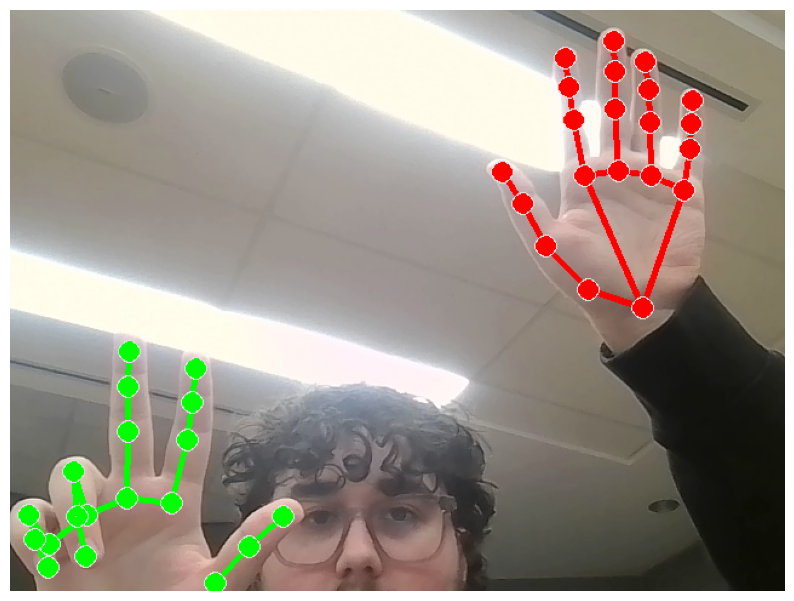

Error loading test2.jpg


In [13]:
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt
import math
from enum import Enum
from collections import Counter

# --- 1. CONFIGURATION & ENUMS ---
class HandShape(Enum):
    ROCK = 0
    PAPER = 1
    SCISSORS = 2
    UNKNOWN = -1

# --- 2. ADAPTIVE AI BRAIN ---
class MarkovPredictor:
    def __init__(self):
        self.matrix = {} 
        self.last_move = None
        self.total_moves = 0 
        
    def train(self, move_sequence):
        for move in move_sequence:
            self.update(move)

    def update(self, current_move):
        self.total_moves += 1
        if self.last_move is not None:
            transition = (self.last_move, current_move)
            self.matrix[transition] = self.matrix.get(transition, 0) + 1
        self.last_move = current_move
        
    def get_prediction(self):
        if self.total_moves < 3 or self.last_move is None:
            return None, "WAITING FOR DATA"
        options = [HandShape.ROCK, HandShape.PAPER, HandShape.SCISSORS]
        best_hand, highest = None, -1
        for opt in options:
            count = self.matrix.get((self.last_move, opt), 0)
            if count > highest: highest, best_hand = count, opt
        return (best_hand, f"PREDICT: {best_hand.name}") if highest > 0 else (None, "UNCERTAIN")

# --- 3. GAME STRATEGY ---
class GameStrategy:
    def __init__(self):
        self.rules = {
            (HandShape.ROCK, HandShape.SCISSORS): 1, (HandShape.ROCK, HandShape.PAPER): -1, (HandShape.ROCK, HandShape.ROCK): 0,
            (HandShape.PAPER, HandShape.ROCK): 1, (HandShape.PAPER, HandShape.SCISSORS): -1, (HandShape.PAPER, HandShape.PAPER): 0,
            (HandShape.SCISSORS, HandShape.PAPER): 1, (HandShape.SCISSORS, HandShape.ROCK): -1, (HandShape.SCISSORS, HandShape.SCISSORS): 0
        }
    def get_payoff(self, my, opp): return self.rules.get((my, opp), 0)

    def solve_hybrid(self, my_hands, opp_hands, prediction=None):
        if prediction is not None and prediction in opp_hands:
            score0 = self.get_payoff(my_hands[0], prediction)
            score1 = self.get_payoff(my_hands[1], prediction)
            if score0 > score1: return my_hands[0], f"KILLER: {my_hands[0].name}"
            elif score1 > score0: return my_hands[1], f"KILLER: {my_hands[1].name}"

        score0 = self.get_payoff(my_hands[0], opp_hands[0]) + self.get_payoff(my_hands[0], opp_hands[1])
        score1 = self.get_payoff(my_hands[1], opp_hands[0]) + self.get_payoff(my_hands[1], opp_hands[1])
        rec = my_hands[0] if score0 >= score1 else my_hands[1]
        return rec, f"NASH: {rec.name}"

# --- 4. COMPUTER VISION (Fixed Logic) ---
class HandDetector:
    def __init__(self):
        self.mp_hands = mp.solutions.hands
        self.hands = self.mp_hands.Hands(static_image_mode=True, max_num_hands=4, min_detection_confidence=0.1, model_complexity=1)
        self.mp_draw = mp.solutions.drawing_utils

    def get_dist(self, p1, p2): return np.hypot(p1.x - p2.x, p1.y - p2.y)

    def classify_gesture(self, hand_landmarks):
        thumb = self.get_dist(hand_landmarks.landmark[0], hand_landmarks.landmark[4]) > self.get_dist(hand_landmarks.landmark[0], hand_landmarks.landmark[2])
        index = self.get_dist(hand_landmarks.landmark[0], hand_landmarks.landmark[8]) > self.get_dist(hand_landmarks.landmark[0], hand_landmarks.landmark[6])
        middle = self.get_dist(hand_landmarks.landmark[0], hand_landmarks.landmark[12]) > self.get_dist(hand_landmarks.landmark[0], hand_landmarks.landmark[10])
        ring = self.get_dist(hand_landmarks.landmark[0], hand_landmarks.landmark[16]) > self.get_dist(hand_landmarks.landmark[0], hand_landmarks.landmark[14])
        pinky = self.get_dist(hand_landmarks.landmark[0], hand_landmarks.landmark[20]) > self.get_dist(hand_landmarks.landmark[0], hand_landmarks.landmark[18])
        
        total = sum([thumb, index, middle, ring, pinky])
        if total <= 1: return HandShape.ROCK
        if index and middle and not ring and not pinky: return HandShape.SCISSORS
        if total >= 4: return HandShape.PAPER
        if total == 3 and index and middle: return HandShape.SCISSORS
        return HandShape.UNKNOWN

    def process_static(self, image_path):
        img = cv2.imread(image_path)
        if img is None: return None, []
        
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        results = self.hands.process(img_rgb)
        detected = [] 
        
        if results.multi_hand_landmarks:
            print(f"\n--- Processing {image_path} ---")
            for i, hand_lms in enumerate(results.multi_hand_landmarks):
                # --- FIX: USE AVERAGE Y INSTEAD OF WRIST ---
                # This calculates the center of the hand, not just the wrist
                y_values = [lm.y for lm in hand_lms.landmark]
                avg_y = np.mean(y_values)
                
                shape = self.classify_gesture(hand_lms)
                detected.append((shape, avg_y))
                
                # Determine Color based on Average Y
                if avg_y < 0.5:
                     print(f"Hand {i}: Y={avg_y:.2f} (Top) -> Red (Opponent)")
                     l_color, c_color = (255, 0, 0), (255, 0, 0)
                else:
                     print(f"Hand {i}: Y={avg_y:.2f} (Bottom) -> Green (You)")
                     l_color, c_color = (0, 255, 0), (0, 255, 0)

                self.mp_draw.draw_landmarks(
                    img_rgb, hand_lms, self.mp_hands.HAND_CONNECTIONS,
                    self.mp_draw.DrawingSpec(color=l_color, thickness=5, circle_radius=5),
                    self.mp_draw.DrawingSpec(color=c_color, thickness=3, circle_radius=2)
                )
        return img_rgb, detected

# --- 5. EXECUTION ---
def analyze_scenario(image_path, simulated_history=None):
    detector = HandDetector()
    strategy = GameStrategy()
    predictor = MarkovPredictor()
    
    if simulated_history: predictor.train(simulated_history)

    img_rgb, raw_data = detector.process_static(image_path)
    if img_rgb is None: print(f"Error loading {image_path}"); return

    # Sort based on Average Y
    all_bottom = [d[0] for d in raw_data if d[1] > 0.5] 
    all_top = [d[0] for d in raw_data if d[1] <= 0.5]
    
    print(f" > Player Has: {[h.name for h in all_bottom]}")
    print(f" > Opponent Has: {[h.name for h in all_top]}")

    if len(all_bottom) >= 2 and len(all_top) >= 2:
        pred_hand, pred_msg = predictor.get_prediction()
        rec_hand, advice = strategy.solve_hybrid(all_bottom[:2], all_top[:2], pred_hand)
        
        h, w, _ = img_rgb.shape
        cv2.rectangle(img_rgb, (0, h-90), (w, h), (0,0,0), -1)
        cv2.putText(img_rgb, f"{advice}", (30, h-30), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 255), 3)
    
    plt.figure(figsize=(10, 8))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.show()

# --- RUN TESTS ---
# Replace with your actual filenames
image_files = ["test1.jpg", "test2.jpg"]
for img in image_files:
    analyze_scenario(img)

In [8]:
import cv2
import os
import glob
import time

def capture_training_data():
    # --- 1. CLEANUP PHASE ---
    # Find all files starting with "test" and ending in ".jpg"
    old_files = glob.glob("test*.jpg")
    for f in old_files:
        try:
            os.remove(f)
            print(f"Deleted old file: {f}")
        except Exception as e:
            print(f"Could not delete {f}: {e}")
            
    print("--- OLD DATA CLEARED ---")
    print("-" * 30)

    # --- 2. SETUP CAMERA ---
    cap = cv2.VideoCapture(0, cv2.CAP_DSHOW)
    # Force 4:3 aspect ratio
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)
    
    if not cap.isOpened():
        print("Error: Could not open webcam.")
        return

    print("--- IMAGE COLLECTION TOOL ---")
    print("Instructions:")
    print("1. Pose your hands (Top = Opponent, Bottom = You)")
    print("2. Press 's' to save the current frame.")
    print("3. Press 'q' to quit early.")
    print("-" * 30)
    
    current_image = 1
    max_images = 5
    
    while current_image <= max_images:
        ret, frame = cap.read()
        if not ret: break
        
        # Create UI copy
        ui = frame.copy()
        h, w, _ = frame.shape
        
        # Draw Guides
        cv2.line(ui, (0, h//2), (w, h//2), (0, 255, 255), 2)
        cv2.putText(ui, "OPPONENT (Top)", (20, h//2 - 20), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2)
        cv2.putText(ui, "PLAYER (Bottom)", (20, h//2 + 40), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        
        # Status Text
        cv2.putText(ui, f"Capture: {current_image}/5", (20, 50), 
                   cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
        cv2.putText(ui, "Press 's' to Save", (20, 90), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (200, 200, 200), 1)

        cv2.imshow("Data Collector", ui)
        
        key = cv2.waitKey(1)
        if key & 0xFF == ord('q'):
            break
        elif key & 0xFF == ord('s'):
            # Save Clean Frame
            filename = f"test{current_image}.jpg"
            cv2.imwrite(filename, frame)
            print(f"[Saved] {filename}")
            
            # Flash Effect
            cv2.rectangle(ui, (0,0), (w,h), (255,255,255), -1)
            cv2.imshow("Data Collector", ui)
            cv2.waitKey(150)
            
            current_image += 1

    cap.release()
    cv2.destroyAllWindows()
    print("Collection Complete! 5 new images saved.")

if __name__ == "__main__":
    capture_training_data()

Deleted old file: test1.jpg
--- OLD DATA CLEARED ---
------------------------------
--- IMAGE COLLECTION TOOL ---
Instructions:
1. Pose your hands (Top = Opponent, Bottom = You)
2. Press 's' to save the current frame.
3. Press 'q' to quit early.
------------------------------
[Saved] test1.jpg
Collection Complete! 5 new images saved.
